In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
import __kalman_smooth__
import copy
import pynumdiff

import figurefirst as fifi
import os

import pickle

import scipy.stats
import scipy.ndimage

import pandas

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
data_directory = '/home/caveman/Downloads/new_bryson_data/'

In [3]:
alphadot_signed = pandas.read_hdf(os.path.join(data_directory, 'alphadot_signed.hdf'))
#alphadot_x = pandas.read_hdf(os.path.join(data_directory, 'alphadot_x.hdf'))
#alphadot_y = pandas.read_hdf(os.path.join(data_directory, 'alphadot_y.hdf'))

In [4]:
frames = alphadot_signed[0].keys().levels[0]

In [5]:
alphadot_meta = pandas.read_hdf(os.path.join(data_directory, 'alphadot_meta.hdf'))

In [6]:
alphas_x = alphadot_meta.xs('alphas_x')
alphas_y = alphadot_meta.xs('alphas_y')
alphas_epi = alphadot_meta.xs('alphas_epi')

In [7]:
vel_accel_time = pandas.read_hdf(os.path.join(data_directory, 'vel_accel_time.hdf'))

In [8]:
dt = vel_accel_time.xs('dt').values[0,0]
scaling = vel_accel_time.xs('scaling').values[0,0] 
t = vel_accel_time.xs('time').values[:,0]

#a_smooth = vel_accel_time.xs('accel_smooth').values[:,0]
a_smooth = vel_accel_time.xs('accel_smooth_1').values[:,0]


v_true = vel_accel_time.xs('velocity_true').values[:,0]
alphadot_sign = vel_accel_time.xs('sign_alphadot').values[:,0]

# Receptive Fields

In [9]:
def get_receptive_field_for_straight_line(alpha_y, y_width, alpha_x, x_width, alphas_epi, center_x=0, center_y=0):
    idx1 = np.where( (np.abs(alphas_y-alpha_y)<y_width) & (np.abs(alphas_x-alpha_x)<x_width) )
    mf = np.zeros_like(alphas_epi)
    mf[idx1] = 1
    return mf

In [10]:
def plot_receptive_field(mf, label='figr', ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    ax.imshow(mf, cmap='bone')

# v over a for receptive field from alphadot

In [11]:
def get_alphadot_window_and_dot(rf, alphadot_signed, square_after_average=True, nth_frame=1, first_frame=0):
    frames = alphadot_signed[0].keys().levels[0][first_frame::nth_frame]
    params = [2, 0.04]
    dtof = 0.0333333
    
    if add_noise:
        def noise(f):
            return np.random.normal(0, 0.5, alphadot_signed.xs(f).values.shape)
    else:
        def noise(f):
            return 0
    
    if square_after_average:
        alphadot_window = [ np.nansum( (alphadot_signed.xs(f).values+noise(f))*rf) / np.nansum(rf) for f in frames]
        alphadot_window = np.array(alphadot_window)
        
        alphadot_window_smooth, alphadot_window_dot = \
            pynumdiff.smooth_finite_difference.butterdiff(alphadot_window, dt*nth_frame, params)
        alphadot_window_smooth_sq = alphadot_window_smooth**2
        
    else:
        alphadot_window = [ np.nansum( (alphadot_signed.xs(f).values+noise(f))*rf) / np.nansum(rf) for f in frames]
        alphadot_window = np.array(alphadot_window)
        alphadot_window_smooth, alphadot_window_dot = \
            pynumdiff.smooth_finite_difference.butterdiff(alphadot_window, dt*nth_frame, params)
        
        alphadot_window_sq = [ np.nansum( ((alphadot_signed.xs(f).values+noise(f))*rf / np.nansum(rf))**2) for f in frames]
        alphadot_window_sq = np.array(alphadot_window_sq)
        alphadot_window_smooth_sq, _ = \
            pynumdiff.smooth_finite_difference.butterdiff(alphadot_window_sq, dt*nth_frame, params)
        
    return alphadot_window_smooth, alphadot_window_dot, alphadot_window_smooth_sq

def get_v_over_a_for_rf_from_alphadot(rf, alphadot, alphas_epi, alphadot_sign, square_after_average=True, 
                                      nth_frame=1, first_frame=0):
    
    #rf[np.where(rf==0)] = np.nan
    csa = np.abs( np.nansum(np.sin( np.abs(alphas_epi)*rf)*np.cos( np.abs(alphas_epi)*rf)) ) / np.nansum(rf)
    
    alphadot_window_smooth, alphadot_window_dot, alphadot_window_smooth_sq = \
        get_alphadot_window_and_dot(rf, alphadot, square_after_average=square_after_average, nth_frame=nth_frame,
                                    first_frame=first_frame)
    
    v_over_a = -1*alphadot_window_smooth*csa / (alphadot_window_smooth_sq - alphadot_window_dot*csa)
    v_over_a = np.abs(v_over_a)*np.sign(alphadot_window_smooth) #*alphadot_sign[first_frame::nth_frame]
        
    return v_over_a, alphadot_window_smooth, alphadot_window_dot

def get_v_est_for_rf_from_alphadot(rf, alphadot, alphas_epi, alphadot_sign, a_smooth, scaling, 
                                   square_after_average=True, nth_frame=1, first_frame=0):
    v_over_a, alphadot_window_smooth, alphadot_window_dot = \
        get_v_over_a_for_rf_from_alphadot(rf, alphadot, alphas_epi, alphadot_sign, 
                                          square_after_average=square_after_average, nth_frame=nth_frame,
                                          first_frame=first_frame)
    v_est = np.abs(a_smooth[first_frame::nth_frame])*v_over_a #*alphadot_signed[first_frame::nth_frame]
    return v_est

In [16]:
results_directory = 'noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg'
add_noise = True
square_after_average = True

#widths = [0.078125, 0.3125, 2.5, 5, 10, 15, 20, 25, 30, 35, 40]
width = 20
alpha_y = 0
alpha_x = 0

rf = get_receptive_field_for_straight_line(alpha_y*np.pi/180., width*np.pi/180., 
                                           alpha_x*np.pi/180., width*np.pi/180., alphas_epi)


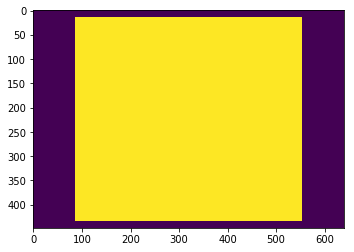

In [17]:
plt.imshow(rf)

In [18]:
v_est = get_v_est_for_rf_from_alphadot(rf, alphadot_signed, alphas_epi, alphadot_sign, a_smooth, 
                                       scaling, square_after_average=square_after_average)

data = {'width': width,
        'alpha_x': alpha_x,
        'alpha_y': alpha_y,
        'v_est': v_est,
        'v_true': v_true,
        'time': t,
        'square_after_average': square_after_average}

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


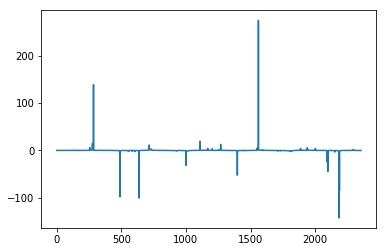

In [20]:
plt.plot(v_est)

# Collect data for different scenarios

In [15]:
results_directory = 'noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg'
add_noise = False
square_after_average = True

widths = [0.078125, 0.3125, 2.5, 5, 10, 15, 20, 25, 30, 35, 40]
#widths = [10]

for width in widths:
    for alpha_y in [-15, -10, -5, 0, 5, 10, 15]: #np.arange(-20, 20+4, 4):
        for alpha_x in [-15, -10, -5, 0, 5, 10, 15]: #np.arange(-24, 24+4, 4):
            print (width, alpha_y, alpha_x)
            
            rf = get_receptive_field_for_straight_line(alpha_y*np.pi/180., width*np.pi/180., 
                                                       alpha_x*np.pi/180., width*np.pi/180., alphas_epi)
            v_est = get_v_est_for_rf_from_alphadot(rf, alphadot_signed, alphas_epi, alphadot_sign, a_smooth, 
                                                   scaling, square_after_average=square_after_average)
            
            data = {'width': width,
                    'alpha_x': alpha_x,
                    'alpha_y': alpha_y,
                    'v_est': v_est,
                    'v_true': v_true,
                    'time': t,
                    'square_after_average': square_after_average}
            
            fname = 'fromalphadot_nomatch_' + str(width) + '_' + str(alpha_y) + '_' + str(alpha_x) + '.pickle'
            
            fname = os.path.join(results_directory, fname)
            
            f = open(fname, 'wb')
            pickle.dump(data, f)
            f.close()

0.078125 -15 -15


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


0.078125 -15 -10
0.078125 -15 -5
0.078125 -15 0
0.078125 -15 5
0.078125 -15 10
0.078125 -15 15
0.078125 -10 -15
0.078125 -10 -10
0.078125 -10 -5
0.078125 -10 0
0.078125 -10 5
0.078125 -10 10
0.078125 -10 15
0.078125 -5 -15
0.078125 -5 -10
0.078125 -5 -5
0.078125 -5 0
0.078125 -5 5
0.078125 -5 10
0.078125 -5 15
0.078125 0 -15
0.078125 0 -10
0.078125 0 -5
0.078125 0 0
0.078125 0 5
0.078125 0 10
0.078125 0 15
0.078125 5 -15
0.078125 5 -10
0.078125 5 -5
0.078125 5 0
0.078125 5 5
0.078125 5 10
0.078125 5 15
0.078125 10 -15
0.078125 10 -10
0.078125 10 -5
0.078125 10 0
0.078125 10 5
0.078125 10 10
0.078125 10 15
0.078125 15 -15
0.078125 15 -10
0.078125 15 -5
0.078125 15 0
0.078125 15 5
0.078125 15 10
0.078125 15 15
0.3125 -15 -15
0.3125 -15 -10
0.3125 -15 -5
0.3125 -15 0
0.3125 -15 5
0.3125 -15 10
0.3125 -15 15
0.3125 -10 -15
0.3125 -10 -10
0.3125 -10 -5
0.3125 -10 0
0.3125 -10 5
0.3125 -10 10
0.3125 -10 15
0.3125 -5 -15
0.3125 -5 -10
0.3125 -5 -5
0.3125 -5 0
0.3125 -5 5
0.3125 -5 10
0.3125 -

In [16]:
results_directory = 'noglobalalphadotavg_vel_ests_for_rfs_nonoise_squarebeforeavg'
add_noise = False
square_after_average = False

widths = [0.078125, 0.3125, 2.5, 5, 10, 15, 20, 25, 30, 35, 40]
#widths = [10]

for width in widths:
    for alpha_y in [-15, -10, -5, 0, 5, 10, 15]: #np.arange(-20, 20+4, 4):
        for alpha_x in [-15, -10, -5, 0, 5, 10, 15]: #np.arange(-24, 24+4, 4):
            print (width, alpha_y, alpha_x)
            
            rf = get_receptive_field_for_straight_line(alpha_y*np.pi/180., width*np.pi/180., 
                                                       alpha_x*np.pi/180., width*np.pi/180., alphas_epi)
            v_est = get_v_est_for_rf_from_alphadot(rf, alphadot_signed, alphas_epi, alphadot_sign, a_smooth, 
                                                   scaling, square_after_average=square_after_average)
            
            data = {'width': width,
                    'alpha_x': alpha_x,
                    'alpha_y': alpha_y,
                    'v_est': v_est,
                    'v_true': v_true,
                    'time': t,
                    'square_after_average': square_after_average}
            
            fname = 'fromalphadot_nomatch_' + str(width) + '_' + str(alpha_y) + '_' + str(alpha_x) + '.pickle'
            
            fname = os.path.join(results_directory, fname)
            
            f = open(fname, 'wb')
            pickle.dump(data, f)
            f.close()

0.078125 -15 -15


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


0.078125 -15 -10
0.078125 -15 -5
0.078125 -15 0
0.078125 -15 5
0.078125 -15 10
0.078125 -15 15
0.078125 -10 -15
0.078125 -10 -10
0.078125 -10 -5
0.078125 -10 0
0.078125 -10 5
0.078125 -10 10
0.078125 -10 15
0.078125 -5 -15
0.078125 -5 -10
0.078125 -5 -5
0.078125 -5 0
0.078125 -5 5
0.078125 -5 10
0.078125 -5 15
0.078125 0 -15
0.078125 0 -10
0.078125 0 -5
0.078125 0 0
0.078125 0 5
0.078125 0 10
0.078125 0 15
0.078125 5 -15
0.078125 5 -10
0.078125 5 -5
0.078125 5 0
0.078125 5 5
0.078125 5 10
0.078125 5 15
0.078125 10 -15
0.078125 10 -10
0.078125 10 -5
0.078125 10 0
0.078125 10 5
0.078125 10 10
0.078125 10 15
0.078125 15 -15
0.078125 15 -10
0.078125 15 -5
0.078125 15 0
0.078125 15 5
0.078125 15 10
0.078125 15 15
0.3125 -15 -15
0.3125 -15 -10
0.3125 -15 -5
0.3125 -15 0
0.3125 -15 5
0.3125 -15 10
0.3125 -15 15
0.3125 -10 -15
0.3125 -10 -10
0.3125 -10 -5
0.3125 -10 0
0.3125 -10 5
0.3125 -10 10
0.3125 -10 15
0.3125 -5 -15
0.3125 -5 -10
0.3125 -5 -5
0.3125 -5 0
0.3125 -5 5
0.3125 -5 10
0.3125 -

In [17]:
results_directory = 'noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg'
add_noise = True
square_after_average = True

widths = [0.078125, 0.3125, 2.5, 5, 10, 15, 20, 25, 30, 35, 40]
#widths = [10]

for width in widths:
    for alpha_y in [-15, -10, -5, 0, 5, 10, 15]: #np.arange(-20, 20+4, 4):
        for alpha_x in [-15, -10, -5, 0, 5, 10, 15]: #np.arange(-24, 24+4, 4):
            print (width, alpha_y, alpha_x)
            
            rf = get_receptive_field_for_straight_line(alpha_y*np.pi/180., width*np.pi/180., 
                                                       alpha_x*np.pi/180., width*np.pi/180., alphas_epi)
            v_est = get_v_est_for_rf_from_alphadot(rf, alphadot_signed, alphas_epi, alphadot_sign, a_smooth, 
                                                   scaling, square_after_average=square_after_average)
            
            data = {'width': width,
                    'alpha_x': alpha_x,
                    'alpha_y': alpha_y,
                    'v_est': v_est,
                    'v_true': v_true,
                    'time': t,
                    'square_after_average': square_after_average}
            
            fname = 'fromalphadot_nomatch_' + str(width) + '_' + str(alpha_y) + '_' + str(alpha_x) + '.pickle'
            
            fname = os.path.join(results_directory, fname)
            
            f = open(fname, 'wb')
            pickle.dump(data, f)
            f.close()

0.078125 -15 -15


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


0.078125 -15 -10
0.078125 -15 -5
0.078125 -15 0
0.078125 -15 5
0.078125 -15 10
0.078125 -15 15
0.078125 -10 -15
0.078125 -10 -10
0.078125 -10 -5
0.078125 -10 0
0.078125 -10 5
0.078125 -10 10
0.078125 -10 15
0.078125 -5 -15
0.078125 -5 -10
0.078125 -5 -5
0.078125 -5 0
0.078125 -5 5
0.078125 -5 10
0.078125 -5 15
0.078125 0 -15
0.078125 0 -10
0.078125 0 -5
0.078125 0 0
0.078125 0 5
0.078125 0 10
0.078125 0 15
0.078125 5 -15
0.078125 5 -10
0.078125 5 -5
0.078125 5 0
0.078125 5 5
0.078125 5 10
0.078125 5 15
0.078125 10 -15
0.078125 10 -10
0.078125 10 -5
0.078125 10 0
0.078125 10 5
0.078125 10 10
0.078125 10 15
0.078125 15 -15
0.078125 15 -10
0.078125 15 -5
0.078125 15 0
0.078125 15 5
0.078125 15 10
0.078125 15 15
0.3125 -15 -15
0.3125 -15 -10
0.3125 -15 -5
0.3125 -15 0
0.3125 -15 5
0.3125 -15 10
0.3125 -15 15
0.3125 -10 -15
0.3125 -10 -10
0.3125 -10 -5
0.3125 -10 0
0.3125 -10 5
0.3125 -10 10
0.3125 -10 15
0.3125 -5 -15
0.3125 -5 -10
0.3125 -5 -5
0.3125 -5 0
0.3125 -5 5
0.3125 -5 10
0.3125 -